In [55]:
import ast  
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import duckdb # I am using DuckDB as I wrote this code in a program called 'Hex' which uses DuckDB.

In [61]:
customers = pd.read_csv('/Users/tarakearney/Downloads/HEX/customers.csv')
events = pd.read_csv('/Users/tarakearney/Downloads/HEX/events.csv')
offers = pd.read_csv('/Users/tarakearney/Downloads/HEX/offers.csv')

customers["member_start_date"] = pd.to_datetime(customers["became_member_on"].astype(str), format="%Y%m%d").dt.strftime("%Y-%m-%d")
customers.drop(columns=['became_member_on'], inplace=True)

In [62]:
# Parsing & expanding 'value' column from string to dictonary for easier extraction
def parse_dict(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) else {}
    except (ValueError, SyntaxError):
        return {}

events_parsed = events['value'].apply(parse_dict) 

# Count times each key appears across all rows
key_counter = Counter()
for row in events_parsed:
    key_counter.update(row.keys())

print("Unique keys and their counts:")
for key, count in key_counter.items():
    print(f"{key}: {count}")

# Normalize dictionary values into separate columns
events_expanded = pd.json_normalize(events_parsed) 

# Combine with the original DataFrame (drop 'value' if no longer needed)
events = pd.concat([events, events_expanded], axis=1).drop(columns=['value']) 

events.head(1)

Unique keys and their counts:
offer id: 134002
amount: 138953
offer_id: 33579
reward: 33579


,customer_id,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN


In [63]:
# Checking to see if the 'offer id' and 'offer_id' columns are ever both non-null before combining
duckdb.sql("""
        SELECT  CASE WHEN "offer id" IS NOT NULL AND "offer_id" IS NOT NULL THEN TRUE ELSE FALSE END AS multiple_id,
                COUNT(DISTINCT customer_id) AS distinct_customers
        FROM    events
        GROUP BY 1
""").df()

,multiple_id,distinct_customers
0,False,17000


In [64]:
# Coalesce Offer ID columns to complete my joining check
events['new_offer_id'] = events.offer_id.combine_first(events["offer id"])
events = events.drop(columns=['offer_id', 'offer id']).rename(columns={"new_offer_id": "offer_id"})

events.head(1)

,customer_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [65]:
# Identify potential missing values when joining tables
def find_missing_values(df1, df2, column):
    set1 = set(df1[column].dropna())
    set2 = set(df2[column].dropna())

    missing_in_df1 = set2 - set1  # Values in df2 but not in df1
    missing_in_df2 = set1 - set2  # Values in df1 but not in df2

    return {
        "missing_in_df1": missing_in_df1,
        "missing_in_df2": missing_in_df2
    }

df1 = customers
df2 = events
df3 = offers

result1 = find_missing_values(df1, df2, 'customer_id')
result2 = find_missing_values(df2, df3, 'offer_id')

print("Values in events but missing in customers:", result1["missing_in_df1"])
print("Values in customers but missing in events:", result1["missing_in_df2"])

print("Values in offers but missing in events:", result2["missing_in_df1"])
print("Values in events but missing in offers:", result2["missing_in_df2"])

Values in events but missing in customers: set()
Values in customers but missing in events: set()
Values in offers but missing in events: set()
Values in events but missing in offers: set()


In [66]:
# Checking to see if the reward in both tables is the same before dropping one
duckdb.sql( """
    SELECT      CASE WHEN o.reward iS NOT NULL AND e.reward IS NOT NULL AND o.reward != e.reward THEN TRUE ELSE FALSE END AS reward,
                COUNT(DISTINCT customer_id) AS distinct_customers
    FROM        events e
    LEFT JOIN   offers o
    ON          e.offer_id = o.offer_id
    GROUP BY    1
""").df()

,reward,distinct_customers
0,False,17000


In [128]:
# Join tables together - this is to show my cleaning and exploration process on all the data at once - instead of repeating it three times. 
df = duckdb.sql("""
    SELECT      c.*,
                e.event,
                e.time,
                e.amount,
                o.*,
                CASE WHEN event != 'transaction' THEN CONCAT(c.customer_id, '|', o.offer_id, '|', ROW_NUMBER() OVER (PARTITION BY customer_id, offer_id, event ORDER BY time)) ELSE NULL END AS id -- It's likely to want to view by unique customer, offer and offer rank (customers can have the same offer multiple times), so we are setting this value up now to make that easier in future.
    FROM        customers c
    LEFT JOIN   events e
    USING       (customer_id)
    LEFT JOIN   offers o
    USING       (offer_id)
""").df()

print(df.count()) # Tracking change of number of values in column
df.head(1) # Tracking changes to format of values in columns

customer_id          306534
gender               272762
age                  306534
income               272762
member_start_date    306534
event                306534
time                 306534
amount               138953
offer_id             167581
offer_type           167581
difficulty           167581
reward               167581
duration             167581
channels             167581
id                   167581
dtype: int64


,customer_id,gender,age,income,member_start_date,event,time,amount,offer_id,offer_type,difficulty,reward,duration,channels,id
0,0009655768c64bdeb2e877511632db8f,M,33,72000.0,2017-04-21,offer viewed,540,NaN,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']",0009655768c64bdeb2e877511632db8f|fafdcd668e374...


In [68]:
# Identifying the data type and amount of missing values per column
df.info(verbose=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_id        306534 non-null  object 
 1   gender             272762 non-null  object 
 2   age                306534 non-null  int64  
 3   income             272762 non-null  float64
 4   member_start_date  306534 non-null  object 
 5   event              306534 non-null  object 
 6   time               306534 non-null  int64  
 7   amount             138953 non-null  float64
 8   offer_id           167581 non-null  object 
 9   offer_type         167581 non-null  object 
 10  difficulty         167581 non-null  Int64  
 11  reward             167581 non-null  Int64  
 12  duration           167581 non-null  Int64  
 13  channels           167581 non-null  object 
 14  id                 167581 non-null  object 
dtypes: Int64(3), float64(2), int64(2), object(8)
memory

In [69]:
# Create a new column 'null_count' that counts null values across the row
df['null_count'] = df.isnull().sum(axis=1)

# Create a new column 'null_columns' that lists column names with null values in each row
df['null_columns'] = df.apply(lambda row: row.index[row.isnull()].tolist(), axis=1)

print(df.count()) # Tracking change of number of values in column
df.head(1) # Tracking changes to format of values in columns

customer_id          306534
gender               272762
age                  306534
income               272762
member_start_date    306534
event                306534
time                 306534
amount               138953
offer_id             167581
offer_type           167581
difficulty           167581
reward               167581
duration             167581
channels             167581
id                   167581
null_count           306534
null_columns         306534
dtype: int64


,customer_id,gender,age,income,member_start_date,event,time,amount,offer_id,offer_type,difficulty,reward,duration,channels,id,null_count,null_columns
0,0020c2b971eb4e9188eac86d93036a77,F,59,90000.0,2016-03-04,offer received,504,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"['email', 'mobile', 'social']",0020c2b971eb4e9188eac86d93036a77|5a8bc65990b24...,1,[amount]


In [70]:
# Grouping by the null column combinations to understand how many customer_ids, offer_ids, and rows are impacted. Prior knowledge of the datasets means I am expecting many results for rows missing 'amount' (non-transaction events) and many results for rows missing offer information (transaction events).
duckdb.sql("""
    SELECT      null_count, 
                null_columns, 
                COUNT(DISTINCT customer_id) AS customers,
                COUNT(DISTINCT offer_id) AS offers,
                COUNT(id) AS rows
    FROM        df 
    GROUP BY    1,2 
    ORDER BY    1,2
""").df()

,null_count,null_columns,customers,offers,rows
0,1,[amount],14820,10,148805
1,3,"[gender, income, amount]",2174,10,18776
2,7,"[offer_id, offer_type, difficulty, reward, dur...",14492,0,0
3,9,"[gender, income, offer_id, offer_type, difficu...",2086,0,0


<AxesSubplot:>

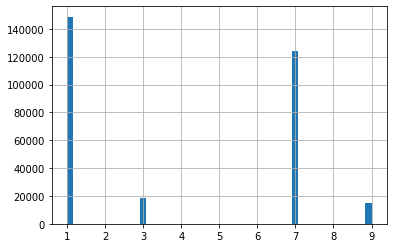

In [71]:
#Understanding how data is missing by row. 
missing_by_row = df.isna().sum(axis='columns')
missing_by_row.hist(bins=50)

In [72]:
# My prior knowledge of the dataset lets me know that transaction events do not have an offer_id, so that is an expected null column. I want to identify if the offer_id is ever missing in an unexpected way.
duckdb.sql("""
    SELECT  CASE    WHEN offer_id IS NULL AND event = 'transaction' THEN 'Expected' 
                    WHEN offer_id IS NULL AND event != 'transaction' THEN 'Unexpected'
                    ELSE NULL
            END AS missing_offer_id,
            COUNT(DISTINCT customer_id) AS distinct_count,
            COUNT(id) AS count
    FROM    df
    GROUP BY 1
""").df()

,missing_offer_id,distinct_count,count
0,None,16994,167581
1,Expected,16578,0


In [73]:
# Looking at rows that I was potentially remove based on missing data - noticed a common element of having an age of 118. Deeper diving shows that every single row has an age of 118.
df.loc[df['gender'].isna() & df['income'].isna()]
# df.loc[df['gender'].isna() & df['income'].isna() & (df['age'] == 118)] # Returns the same number of rows

,customer_id,gender,age,income,member_start_date,event,time,amount,offer_id,offer_type,difficulty,reward,duration,channels,id,null_count,null_columns
2,0069a50874d846438e58acff5e594725,None,118,NaN,2016-05-03,offer received,504,NaN,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,"['web', 'email', 'mobile']",0069a50874d846438e58acff5e594725|2906b810c7d44...,3,"[gender, income, amount]"
3,0069a50874d846438e58acff5e594725,None,118,NaN,2016-05-03,offer received,576,NaN,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,"['web', 'email', 'mobile']",0069a50874d846438e58acff5e594725|2906b810c7d44...,3,"[gender, income, amount]"
9,0092a132ead946ceb30d11a1ed513d20,None,118,NaN,2018-05-02,offer received,576,NaN,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,"['web', 'email', 'mobile']",0092a132ead946ceb30d11a1ed513d20|2906b810c7d44...,3,"[gender, income, amount]"
10,0092a132ead946ceb30d11a1ed513d20,None,118,NaN,2018-05-02,offer received,504,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"['email', 'mobile', 'social']",0092a132ead946ceb30d11a1ed513d20|5a8bc65990b24...,3,"[gender, income, amount]"
64,0193c118afe84208b33ffeb1dcb277d8,None,118,NaN,2018-04-27,offer received,576,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"['email', 'mobile', 'social']",0193c118afe84208b33ffeb1dcb277d8|5a8bc65990b24...,3,"[gender, income, amount]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306439,fe4e1ca704f5436ab5a213740e855925,None,118,NaN,2018-03-06,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",fe4e1ca704f5436ab5a213740e855925|4d5c57ea9a694...,3,"[gender, income, amount]"
306454,ff10813b5b234830a6c2a43ac7ae765e,None,118,NaN,2018-03-08,offer received,336,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,"['web', 'email']",ff10813b5b234830a6c2a43ac7ae765e|0b1e1539f2cc4...,3,"[gender, income, amount]"
306455,ff171032c3484478ae213de018a51402,None,118,NaN,2017-10-11,offer viewed,450,NaN,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"['web', 'email', 'mobile']",ff171032c3484478ae213de018a51402|3f207df678b14...,3,"[gender, income, amount]"
306456,ff171032c3484478ae213de018a51402,None,118,NaN,2017-10-11,offer viewed,594,NaN,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"['web', 'email', 'mobile']",ff171032c3484478ae213de018a51402|3f207df678b14...,3,"[gender, income, amount]"


In [74]:
# Remove rows based on nulls - Roughly 11% of rows are missing gender and income. For this dataset I believe I have enough data to compensate for the removal of these rows, and that this missing data is important enough to warrant removal. This was also remove all the ages of 118, which is an outlier.
df = df.dropna(subset=['gender', 'income'], how='all').drop(columns=['null_count','null_columns']) #Also dropping null counting columns, they have served their purpose.

print(df.count()) # Tracking change of number of values in column
df.head(1) # Tracking changes to format of values in columns

customer_id          272762
gender               272762
age                  272762
income               272762
member_start_date    272762
event                272762
time                 272762
amount               123957
offer_id             148805
offer_type           148805
difficulty           148805
reward               148805
duration             148805
channels             148805
id                   148805
dtype: int64


,customer_id,gender,age,income,member_start_date,event,time,amount,offer_id,offer_type,difficulty,reward,duration,channels,id
0,0020c2b971eb4e9188eac86d93036a77,F,59,90000.0,2016-03-04,offer received,504,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"['email', 'mobile', 'social']",0020c2b971eb4e9188eac86d93036a77|5a8bc65990b24...


In [75]:
# This dataset does contain duplicates - this is because a customer can use the same offer repeatedly, at the same time.
df_duplicates = df[df.drop(columns=['id']).duplicated()] #id is a unique variable that I created, so it will make no duplicates show up, which is why I'm removing this.
df_duplicates

,customer_id,gender,age,income,member_start_date,event,time,amount,offer_id,offer_type,difficulty,reward,duration,channels,id
62,01925607d99c460996c281f17cdbb9e2,F,57,116000.0,2015-11-19,offer completed,510,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",01925607d99c460996c281f17cdbb9e2|4d5c57ea9a694...
953,0d0c8b66f0954686ad82e5eb8a61baf6,M,78,50000.0,2017-06-07,offer completed,660,NaN,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,"['web', 'email', 'mobile']",0d0c8b66f0954686ad82e5eb8a61baf6|2906b810c7d44...
1931,1acb3e87e3304271a3c917cc80a53780,F,87,76000.0,2016-05-14,offer completed,600,NaN,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"['email', 'mobile', 'social']",1acb3e87e3304271a3c917cc80a53780|ae264e3637204...
2177,1dc461d98e5c4a5a9b320b78e0ca1efd,F,29,64000.0,2017-08-02,offer completed,642,NaN,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']",1dc461d98e5c4a5a9b320b78e0ca1efd|fafdcd668e374...
4229,39437fa966ad4de0bc8afe8906778822,F,54,52000.0,2015-08-24,offer completed,426,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",39437fa966ad4de0bc8afe8906778822|4d5c57ea9a694...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305150,ede78d4917c64e09a30eec8fcf479d55,M,27,69000.0,2017-04-11,offer completed,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",ede78d4917c64e09a30eec8fcf479d55|f19421c1d4aa4...
305570,f2e49f5002c540eb92ca320fea990319,F,45,73000.0,2018-06-07,offer completed,612,NaN,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"['email', 'mobile', 'social']",f2e49f5002c540eb92ca320fea990319|ae264e3637204...
305857,f709aca8c4e54792b438caddff279fe5,M,62,113000.0,2015-09-09,offer completed,606,NaN,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",f709aca8c4e54792b438caddff279fe5|f19421c1d4aa4...
306038,f92fd305868d4c06a64c0eaa38a4b498,M,74,80000.0,2018-01-14,offer completed,576,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,"['web', 'email', 'mobile']",f92fd305868d4c06a64c0eaa38a4b498|9b98b8c7a33c4...


In [76]:
# This is how I identify the cause of the duplicates - which in this case is that the 'offer completed' is duplicating, which we confirm by checking to see is there is a coresponding transaction. Same number of rows confirms my theory and I can move forward with removal of duplicate rows.
duckdb.sql("""
    SELECT      COUNT(DISTINCT id) 
    FROM        (
                    SELECT      id,
                                COUNT(CASE WHEN event = 'offer completed' THEN CONCAT(customer_id,time) ELSE NULL END) AS offers_completed,
                                COUNT(CASE WHEN event = 'transaction' THEN CONCAT(customer_id,time) ELSE NULL END) AS transactions
                    FROM        df 
                    WHERE       id IN (SELECT DISTINCT id FROM df_duplicates)
                    GROUP BY    1
                    HAVING      offers_completed > transactions
                )
""").df()

,count(DISTINCT id)
0,374


In [77]:
# Filter out rows where the 'id' is in df_duplicates
ids_to_remove = df_duplicates['id']
df = df[~df['id'].isin(ids_to_remove)]

print(df.count()) # Tracking change of number of values in column
df.head(1) # Tracking changes to format of values in columns

customer_id          271807
gender               271807
age                  271807
income               271807
member_start_date    271807
event                271807
time                 271807
amount               123957
offer_id             147850
offer_type           147850
difficulty           147850
reward               147850
duration             147850
channels             147850
id                   147850
dtype: int64


,customer_id,gender,age,income,member_start_date,event,time,amount,offer_id,offer_type,difficulty,reward,duration,channels,id
0,0020c2b971eb4e9188eac86d93036a77,F,59,90000.0,2016-03-04,offer received,504,NaN,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"['email', 'mobile', 'social']",0020c2b971eb4e9188eac86d93036a77|5a8bc65990b24...


In [78]:
# Find 'tailedness'. High kurtosis means higher number of outliers
df.kurt(numeric_only=True)

age            -0.555634
income         -0.458882
time           -1.018223
amount        413.259069
difficulty      0.709702
reward         -0.868418
duration       -0.785844
dtype: float64

<AxesSubplot:>

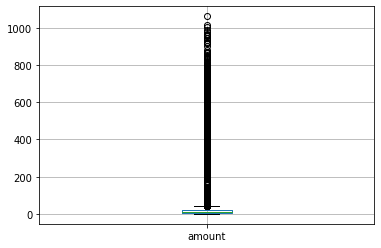

In [79]:
# Visualisation of 'amount' column. Helps to tell if there are extreme outliers
df.boxplot(column=['amount'])

In [80]:
# Analyzing the only potential outliers - but between this table and the boxplot I have decided to not remove any data as it is valid, true, data despite the taildness of it.
df.loc[df['amount'] > 1000]

,customer_id,gender,age,income,member_start_date,event,time,amount,offer_id,offer_type,difficulty,reward,duration,channels,id
20584,6cf884a6c5ae4b2daccb6d3108028fef,F,58,110000.0,2015-08-06,transaction,630,1062.28,None,None,<NA>,<NA>,<NA>,None,None
138198,5ecaea5c8bf44ae4a65838d9d066c909,F,55,97000.0,2018-03-03,transaction,102,1001.85,None,None,<NA>,<NA>,<NA>,None,None
168805,454b00bdd77c4f588eb9f6cafd81dc5d,F,53,89000.0,2018-03-29,transaction,690,1015.73,None,None,<NA>,<NA>,<NA>,None,None


In [81]:
# In this dataset a transaction can only be attributed to an offer if it occurs at the same time. We are now removing transactions from the main table and re-joining it to the correct offer to make future analysis simpler. We are also re-running the id as, with the duplicate removal, it is now outdated.
customer_offer_table = duckdb.sql("""
    SELECT      CONCAT(df.customer_id, '|', offer_id, '|', ROW_NUMBER() OVER (PARTITION BY df.customer_id, offer_id, event ORDER BY df.time)) AS id,
                df.customer_id,
                gender,
                age,
                CASE    WHEN age BETWEEN 18 AND 24 THEN 'Young Adult'
                        WHEN age BETWEEN 25 AND 34 THEN 'Early Career'
                        WHEN age BETWEEN 35 AND 44 THEN 'Mid Career'
                        WHEN age BETWEEN 45 AND 54 THEN 'Established Career'
                        WHEN age BETWEEN 55 AND 64 THEN 'Pre-Retirement'
                        WHEN age >= 65 THEN 'Seniors'
                        ELSE 'Missing'
                END AS age_group,
                income,
                CASE    WHEN income <= 30000 THEN 'Lower Income'
                        WHEN income BETWEEN 30000 AND 49999 THEN 'Lower - Middle Income'
                        WHEN income BETWEEN 50000 AND 74999 THEN 'Middle Income'
                        WHEN income BETWEEN 75000 AND 99999 THEN 'Middle - Upper Income'
                        WHEN income >= 100000 THEN 'Upper Income'
                        ELSE 'Missing'
                END AS income_group,
                member_start_date,
                DATE_DIFF('year', CAST(member_start_date AS DATE), CURRENT_DATE) AS membership_years,
                event,
                df.time,
                offer_id,
                offer_type,
                difficulty,
                reward,
                duration,
                channels,
                transactions.amount
    FROM        df
    LEFT JOIN   (SELECT customer_id, time, amount FROM df WHERE event = 'transaction') transactions
    ON          df.customer_id = transactions.customer_id
    AND         df.time = transactions.time
    AND         df.event = 'offer completed'
    WHERE       event != 'transaction'
""").df()

print(customer_offer_table.count()) # Tracking change of number of values in column
customer_offer_table.head(1) # Tracking changes to format of values in columns

id                   147850
customer_id          147850
gender               147850
age                  147850
age_group            147850
income               147850
income_group         147850
member_start_date    147850
membership_years     147850
event                147850
time                 147850
offer_id             147850
offer_type           147850
difficulty           147850
reward               147850
duration             147850
channels             147850
amount                32070
dtype: int64


,id,customer_id,gender,age,age_group,income,income_group,member_start_date,membership_years,event,time,offer_id,offer_type,difficulty,reward,duration,channels,amount
0,e3b3486b202c4a399b6b64f2de81f516|4d5c57ea9a694...,e3b3486b202c4a399b6b64f2de81f516,M,76,Seniors,56000.0,Middle Income,2014-08-14,11,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",NaN


In [82]:
# Double checking that all completed offers matched with a transaction. The response is empty, so we're looking good!
duckdb.sql("""
    select      *
    from        customer_offer_table
    WHERE       event = 'offer completed'
    AND         amount IS NULL
""").df()

,id,customer_id,gender,age,age_group,income,income_group,member_start_date,membership_years,event,time,offer_id,offer_type,difficulty,reward,duration,channels,amount


In [83]:
# Analyzing numeric columns to identify obvious errors
customer_offer_table.describe()

,age,income,membership_years,time,difficulty,reward,duration,amount
count,147850.000000,147850.000000,147850.000000,147850.000000,147850.000000,147850.000000,147850.000000,32070.000000
mean,54.775942,66390.125127,8.423287,353.646412,7.873913,4.437768,6.618904,20.846990
std,17.190409,21493.167201,1.186845,198.451246,5.038011,3.374330,2.133611,40.892243
min,18.000000,30000.000000,7.000000,0.000000,0.000000,0.000000,3.000000,0.150000
25%,43.000000,51000.000000,8.000000,168.000000,5.000000,2.000000,5.000000,11.410000
50%,56.000000,65000.000000,8.000000,408.000000,10.000000,5.000000,7.000000,17.070000
75%,67.000000,81000.000000,9.000000,510.000000,10.000000,5.000000,7.000000,23.600000
max,101.000000,120000.000000,12.000000,714.000000,20.000000,10.000000,10.000000,1015.730000


In [84]:
# Analyzing columns, mainly to see most common string values, but also to see a distinct count for numerical columns
def most_common_values(df, top_n=10):
    result = {}
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, list)).any():
            df[col] = df[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)

        if df[col].dtype == "object" or df[col].dtype.name == "category":
            result[col] = df[col].value_counts().head(top_n).to_dict()
        else:
            result[col] = df[col].nunique()  # Just show distinct count for numerical columns
    return result

# Display results
common_values = most_common_values(customer_offer_table)
for col, values in common_values.items():
    print(f"{col}: {values}")


id: {'e3b3486b202c4a399b6b64f2de81f516|4d5c57ea9a6940dd891ad53e9dbe8da0|1': 3, 'e8286cf0c4f04ebe9f4f3d41f7e063bd|fafdcd668e3743c1bb461111dcafc2a4|1': 3, '14462e564e044822b4b29684512ee428|fafdcd668e3743c1bb461111dcafc2a4|1': 3, 'ea1c5394b7194cc38bcd22b2478d559d|4d5c57ea9a6940dd891ad53e9dbe8da0|1': 3, 'ea58bf7f48d3483eb41509aa2382a81a|f19421c1d4aa40978ebb69ca19b0e20d|1': 3, '144581d274654cf3a6af4de58603f08d|ae264e3637204a6fb9bb56bc8210ddfd|1': 3, 'ea6946e978374cd3a2d9257c32e235ae|2298d6c36e964ae4a3e7e9706d1fb8c2|1': 3, 'ea6a1589b9d545109077c1481b917599|2298d6c36e964ae4a3e7e9706d1fb8c2|1': 3, '141e082d59ef48759823ab1ddcfe1f7a|2906b810c7d4411798c6938adc9daaa5|1': 3, '1418e71469474b7fa160cd76b198cb08|2906b810c7d4411798c6938adc9daaa5|1': 3}
customer_id: {'dc8ec6bd92fd4a519b1a4dbd645e7c8c': 18, '43d31551643c4dc181cd13204b2dcff9': 18, '9b9858f0a599424688bc2c3d0d2a6d3b': 18, '155a3cc8647a4d74ad15111d2b569e63': 18, '9bfeb65da0cf4bca95da96ef8684ace4': 18, 'dcf78fa986de4d5992c3c05df63bb3ee': 18, '

# Analytics



In [85]:
filterable_main_table = duckdb.sql("""
    SELECT  *, CONCAT(offer_type, '-', difficulty, '-', reward, '-', duration) AS offer_combined
    FROM    customer_offer_table
    WHERE   offer_type != 'informational'
""").df()

print(filterable_main_table.count()) # Tracking change of number of values in column
filterable_main_table.head(1) # Tracking changes to format of values in columns

id                   125190
customer_id          125190
gender               125190
age                  125190
age_group            125190
income               125190
income_group         125190
member_start_date    125190
membership_years     125190
event                125190
time                 125190
offer_id             125190
offer_type           125190
difficulty           125190
reward               125190
duration             125190
channels             125190
amount                32070
offer_combined       125190
dtype: int64


,id,customer_id,gender,age,age_group,income,income_group,member_start_date,membership_years,event,time,offer_id,offer_type,difficulty,reward,duration,channels,amount,offer_combined
0,e3b3486b202c4a399b6b64f2de81f516|4d5c57ea9a694...,e3b3486b202c4a399b6b64f2de81f516,M,76,Seniors,56000.0,Middle Income,2014-08-14,11,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",NaN,bogo-10-10-5


In [86]:
transaction_totals_by_customer = duckdb.sql("""
    SELECT      df.customer_id, 
                CONCAT(demo.age_group, ', ', demo.income_group) AS demographic_group,
                demo.age_group,
                demo.age,
                demo.income_group,
                demo.income,
                demo.gender,
                ROUND(COUNT(DISTINCT CASE WHEN f.amount IS NOT NULL THEN f.id ELSE NULL END) * 1.0 / COUNT(df.customer_id), 4) AS percent_of_transactions_with_offer,
                ROUND((MEDIAN(f.amount)-MEDIAN(CASE WHEN f.customer_id IS NULL THEN df.amount ELSE NULL END)), 2) AS median_difference_with_offer,
                ROUND((MIN(f.amount)-MIN(CASE WHEN f.customer_id IS NULL THEN df.amount ELSE NULL END)), 2) AS min_difference_with_offer,
                -- Non-Offer Transactions
                COUNT(CASE WHEN f.customer_id IS NULL THEN df.customer_id ELSE NULL END) AS regular_total_transactions, 
                ROUND(COALESCE(SUM(CASE WHEN f.customer_id IS NULL THEN df.amount ELSE NULL END), 0), 2) AS regular_total_spent,
                ROUND(COALESCE(MIN(CASE WHEN f.customer_id IS NULL THEN df.amount ELSE NULL END), 0), 2) AS regular_min_amount,
                ROUND(COALESCE(MEDIAN(CASE WHEN f.customer_id IS NULL THEN df.amount ELSE NULL END), 0), 2) AS regular_median_amount,
                ROUND(COALESCE(MAX(CASE WHEN f.customer_id IS NULL THEN df.amount ELSE NULL END), 0), 2) AS regular_max_amount,
                -- Offer Transactions
                COUNT(f.customer_id) AS offers_total_transactions, 
                ROUND(COALESCE(SUM(f.amount), 0), 2) AS offers_total_spent,
                ROUND(COALESCE(MIN(f.amount), 0), 2) AS offers_min_amount,
                ROUND(COALESCE(MEDIAN(f.amount), 0), 2) AS offers_median_amount,
                ROUND(COALESCE(MAX(f.amount), 0), 2) AS offers_max_amount,
                -- Totals
                COUNT(df.customer_id) AS total_transactions,
                COALESCE(MEDIAN(df.amount), 0) AS median_amount,
                CASE    
                    WHEN total_transactions BETWEEN 1 AND 4 THEN 'Low Frequency'
                    WHEN total_transactions BETWEEN 5 AND 7 THEN 'Low-Med Frequency'
                    WHEN total_transactions BETWEEN 8 AND 10 THEN 'Med-Low Frequency'
                    WHEN total_transactions BETWEEN 11 AND 13 THEN 'Med-High Frequency'
                    WHEN total_transactions BETWEEN 14 AND 18 THEN 'High-Med Frequency'
                    WHEN total_transactions BETWEEN 19 AND 36 THEN 'High Frequency'
                    ELSE 'Error'
                END AS transaction_cluster -- Added after cluster analysis
    FROM        df 
    LEFT JOIN   filterable_main_table f 
    ON          f.customer_id = df.customer_id
    AND         f.time = df.time
    AND         f.event = 'offer completed'
    JOIN        (SELECT DISTINCT customer_id, age_group, income_group, gender, income, age FROM filterable_main_table) demo -- Remove customers who have transactions but have never been sent an offer / only been sent informational offers
    ON          demo.customer_id = df.customer_id
    WHERE       df.event = 'transaction'
    GROUP BY    1, 2, 3, 4, 5, 6, 7
    HAVING      median_amount < 100 -- Removing outliers I identified during analysis. I want to keep them in my original dataset, I just want to remove them here.
""").df()

print(transaction_totals_by_customer.count()) # Tracking change of number of values in column
transaction_totals_by_customer.head(1) # Tracking changes to format of values in columns

customer_id                           14429
demographic_group                     14429
age_group                             14429
age                                   14429
income_group                          14429
income                                14429
gender                                14429
percent_of_transactions_with_offer    14429
median_difference_with_offer          11568
min_difference_with_offer             11568
regular_total_transactions            14429
regular_total_spent                   14429
regular_min_amount                    14429
regular_median_amount                 14429
regular_max_amount                    14429
offers_total_transactions             14429
offers_total_spent                    14429
offers_min_amount                     14429
offers_median_amount                  14429
offers_max_amount                     14429
total_transactions                    14429
median_amount                         14429
transaction_cluster             

,customer_id,demographic_group,age_group,age,income_group,income,gender,percent_of_transactions_with_offer,median_difference_with_offer,min_difference_with_offer,...,regular_median_amount,regular_max_amount,offers_total_transactions,offers_total_spent,offers_min_amount,offers_median_amount,offers_max_amount,total_transactions,median_amount,transaction_cluster
0,12f0142f294c4977add82252007556b8,"Seniors, Upper Income",Seniors,75,Upper Income,103000.0,M,0.625,8.64,2.51,...,21.18,31.72,5,144.56,20.04,29.82,34.34,8,28.8,Med-Low Frequency


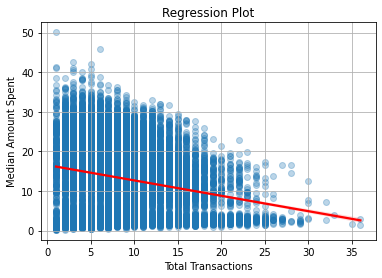

In [ ]:
# This Regression Plot is what led me to look into spending and frequency, leading to my discovery that they are the best indication of customer behaviour

plt.subplot(1, 1, 1)
sns.regplot(data=transaction_totals_by_customer, x='total_transactions', y='median_amount', scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.xlabel('Total Transactions')
plt.ylabel('Median Amount Spent')
plt.title('Regression Plot')
plt.grid()

plt.show()

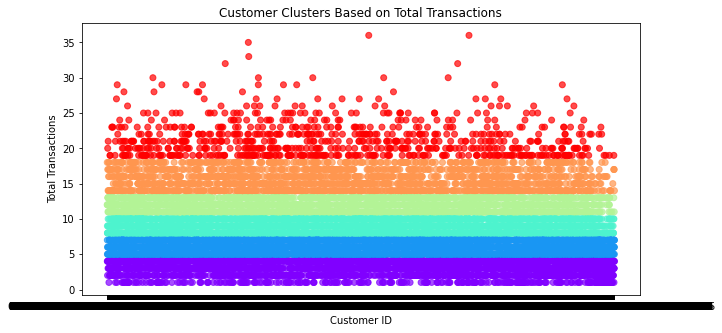


Cluster Summary for total_transactions:

                            min  median  max  count
total_transactions_cluster                         
1                             1     3.0    4   3118
2                             5     6.0    7   3863
3                             8     9.0   10   2921
4                            11    12.0   13   2035
5                            14    15.0   18   1749
6                            19    21.0   36    743


In [ ]:
# I originally did other clusting which was a combination of features - but I was looking for something a bit more static so I chose to look at the values individually and create my own groupings

# List of features to cluster on
features = ['total_transactions']

# Loop through features
for feature in features:
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(transaction_totals_by_customer[[feature]])

    # Apply Clustering
    kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
    cluster_col = f"{feature}_cluster"
    transaction_totals_by_customer[cluster_col] = kmeans.fit_predict(X_scaled)

    # Sort clusters by median feature value (optional)
    transaction_totals_by_customer[cluster_col] = (
        transaction_totals_by_customer.groupby(cluster_col)[feature]
        .transform('median')
        .rank(method='dense')
        .astype(int)
    )

    # Plot Clusters
    plt.figure(figsize=(10, 5))
    plt.scatter(transaction_totals_by_customer['customer_id'], transaction_totals_by_customer[feature], 
                c=transaction_totals_by_customer[cluster_col], cmap='rainbow', alpha=0.7)
    plt.xlabel('Customer ID')
    plt.ylabel(feature.replace("_", " ").title())
    plt.title(f'Customer Clusters Based on {feature.replace("_", " ").title()}')
    plt.show()

    print(f"\nCluster Summary for {feature}:\n")
    print(transaction_totals_by_customer.groupby(cluster_col)[feature].agg(['min', 'median', 'max', 'count']))

In [ ]:
# I decided to cluster on min, median, and max for median amount spent. This helped to identify erratric customers, which I would like removed from the dataset, and group them more accurately based on behaviour.

# Set Values 
table = transaction_totals_by_customer
original_categories = ['regular_min_amount','regular_median_amount','regular_max_amount']
new_categories = ['customer_id','Min Spend','Median Spend','Max Spend']
n = 5

# Function to convert  
def listToString(s): 
    str1 = '' 
    for ele in s: 
        str1 += ele 
    return str1

cluster = table.loc[:,['customer_id']]
cluster[original_categories] = table.loc[:,original_categories]
cluster.fillna(0, inplace = True)

cluster_normalized = cluster.copy()

# Normalize Data

cluster_normalized[new_categories[1]] = (cluster_normalized[original_categories[0]] - np.mean(cluster_normalized[original_categories[0]])) / (np.max(cluster_normalized[original_categories[0]]) - np.min (cluster_normalized[original_categories[0]]))
cluster_normalized[new_categories[2]] = (cluster_normalized[original_categories[1]] - np.mean(cluster_normalized[original_categories[1]])) / (np.max(cluster_normalized[original_categories[1]]) - np.min (cluster_normalized[original_categories[1]]))
cluster_normalized[new_categories[3]] = (cluster_normalized[original_categories[2]] - np.mean(cluster_normalized[original_categories[2]])) / (np.max(cluster_normalized[original_categories[2]]) - np.min (cluster_normalized[original_categories[2]]))

cluster_normalized.drop(columns=original_categories,inplace = True)

clusterlabels = AgglomerativeClustering(n_clusters = n, linkage='ward')
clusterlabels_output = clusterlabels.fit_predict(cluster_normalized[new_categories[1:4]])

cluster_normalized["labels"] = clusterlabels.labels_

#Normalized Fig
xlab_normalized = (listToString([new_categories[1]]))
ylab_normalized = (listToString([new_categories[2]]))
zlab_normalized = (listToString([new_categories[3]]))
aid_normalized = (listToString([new_categories[0]]))

cols_normalized = [xlab_normalized, ylab_normalized, zlab_normalized, 'labels', aid_normalized]
df_normalized = cluster_normalized.loc[:,cols_normalized]
df_normalized.labels = df_normalized.labels.astype('str')

#Normalized Fig
normalizedfig = px.scatter_3d(df_normalized, 
                    x=xlab_normalized, 
                    y=ylab_normalized,
                    z=zlab_normalized,
                    color='labels',
                    hover_data = aid_normalized, 
                    width=1000, 
                    height=1000)

normalizedfig

In [87]:
spend_type = duckdb.sql("""
    SELECT  labels, 
            CASE    WHEN labels = 0 THEN 'Med-High Spend'
                    WHEN labels = 1 THEN 'Med-Low Spend'
                    WHEN labels = 2 THEN 'Low Spend'
                    WHEN labels = 3 THEN 'Erratic Small-Segment'
                    WHEN labels = 4 THEN 'High Spend'
                    ELSE NULL 
            END     AS spend_type,
            COUNT(DISTINCT customer_id) AS total_customers, 
            MEDIAN(regular_min_amount) AS min_amount_regular,
            MEDIAN(regular_median_amount) AS median_amount_regular,
            MEDIAN(regular_max_amount) AS max_amount_regular
    FROM    df_normalized
    LEFT JOIN   transaction_totals_by_customer USING (customer_id)
    WHERE   df_normalized."Max Spend" < 0.025 -- Removing the more erratic-purchase history customers for more reliable results.
    GROUP BY    labels, spend_type
""").df() 

spend_type

,labels,spend_type,total_customers,min_amount_regular,median_amount_regular,max_amount_regular
0,0,Med-High Spend,3385,16.860,22.05,28.46
1,1,Med-Low Spend,3727,8.910,14.62,22.53
2,4,High Spend,582,26.835,29.11,31.78
3,2,Low Spend,6425,0.720,2.58,6.43


In [88]:
customer_table = duckdb.sql("""
    SELECT      tt.customer_id, 
                tt.income_group,
                tt.age_group,
                tt.gender,
                tt.transaction_cluster,
                s.spend_type,
                CASE 
                    WHEN transaction_cluster IN ('High Frequency', 'High-Med Frequency') THEN CONCAT('Regular Customer - ', spend_type, 'er')
                    WHEN transaction_cluster IN ('Med-Low Frequency', 'Med-High Frequency') THEN CONCAT('Standard Customer - ', spend_type, 'er')
                    WHEN transaction_cluster IN ('Low Frequency', 'Low-Med Frequency') THEN CONCAT('Occasional Customer - ', spend_type, 'er')
                END AS segment, -- Naming conventions created later and added back in here.
                tt.total_transactions,
                tt.regular_median_amount,
                COALESCE(tt.percent_of_transactions_with_offer, 0) AS proportion_of_transactions_with_offer,
                COALESCE(tt.median_difference_with_offer, 0) AS median_offer_impact_per_customer,
                COALESCE(COUNT(DISTINCT CASE WHEN f.event = 'offer completed' THEN f.id ELSE NULL END) * 1.0 / COUNT(DISTINCT CASE WHEN f.event = 'offer received' THEN f.id ELSE NULL END), 0) AS offers_completed
    FROM        transaction_totals_by_customer tt
    JOIN        df_normalized c 
    USING       (customer_id)
    JOIN        spend_type s 
    USING       (labels)
    JOIN        filterable_main_table f 
    ON          f.customer_id = tt.customer_id
    AND         f.event IN ('offer completed', 'offer received')
    GROUP BY    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
    HAVING      segment NOT IN ('Regular Customer - High Spender', 'Standard Customer - High Spender') -- These groups are too small to determine insights from
""").df() 

print(customer_table.count()) # Tracking change of number of values in column
customer_table.head(1) # Tracking changes to format of values in columns

customer_id                              14238
income_group                             14238
age_group                                14238
gender                                   14238
transaction_cluster                      14238
spend_type                               14238
segment                                  14238
total_transactions                       14238
regular_median_amount                    14238
proportion_of_transactions_with_offer    14238
median_offer_impact_per_customer         14238
offers_completed                         14238
dtype: int64


,customer_id,income_group,age_group,gender,transaction_cluster,spend_type,segment,total_transactions,regular_median_amount,proportion_of_transactions_with_offer,median_offer_impact_per_customer,offers_completed
0,8c3375bdfa3348f2a69dafbb675f034d,Middle - Upper Income,Seniors,F,Med-High Frequency,Med-Low Spend,Standard Customer - Med-Low Spender,12,16.4,0.4167,9.68,1.0


In [89]:
duckdb.sql("""
    SELECT      segment, 
                COUNT(DISTINCT customer_id) AS customers_in_customer_type,
                SUM(COUNT(DISTINCT customer_id)) OVER () AS all_customers,
                ROUND(customers_in_customer_type * 100 / all_customers ,2) AS percent_of_customers_in_customer_type
    FROM        customer_table
    GROUP BY    1
    ORDER BY    1
""").df()

,segment,customers_in_customer_type,all_customers,percent_of_customers_in_customer_type
0,Occasional Customer - High Spender,530,14238.0,3.72
1,Occasional Customer - Low Spender,3090,14238.0,21.70
2,Occasional Customer - Med-High Spender,2068,14238.0,14.52
3,Occasional Customer - Med-Low Spender,1263,14238.0,8.87
4,Regular Customer - Low Spender,1642,14238.0,11.53
5,Regular Customer - Med-High Spender,113,14238.0,0.79
6,Regular Customer - Med-Low Spender,706,14238.0,4.96
7,Standard Customer - Low Spender,1766,14238.0,12.40
8,Standard Customer - Med-High Spender,1215,14238.0,8.53
9,Standard Customer - Med-Low Spender,1845,14238.0,12.96


In [90]:
frequency_spend_table = duckdb.sql( """
    SELECT  transaction_cluster,
            spend_type,
            COUNT(DISTINCT customer_id) AS customers,
            MEDIAN(offers_completed) AS offers_completed,
            MEDIAN(proportion_of_transactions_with_offer) AS proportion_of_transactions_with_offer,
            MEDIAN(median_offer_impact_per_customer) AS median_offer_impact_per_customer
    FROM    customer_table 
    GROUP BY 1, 2
    HAVING   customers > 50  
""").df()

duckdb.sql("""
    SELECT  CONCAT('Regular Customer - ', spend_type, 'er') AS "Segment",
            SUM(customers) AS "Customers In Segment",
            CONCAT(CONCAT(ROUND(MIN(offers_completed) * 100, 0), '%'), ' - ', CONCAT(ROUND(MAX(offers_completed) * 100, 0), '%')) AS "% of Recieved Offers Completed",
            CONCAT(CONCAT(ROUND(MIN(proportion_of_transactions_with_offer) * 100, 0), '%'), ' - ', CONCAT(ROUND(MAX(proportion_of_transactions_with_offer) * 100, 0), '%')) AS "% of Transactions That Were Offers",
            CONCAT(CONCAT('$', ROUND(MIN(median_offer_impact_per_customer), 4)), ' - ', CONCAT('$', ROUND(MAX(median_offer_impact_per_customer), 4))) AS "Median Offer Impact"
    FROM    frequency_spend_table 
    WHERE   transaction_cluster IN ('High Frequency', 'High-Med Frequency')
    GROUP BY 1
    
    UNION ALL 
    SELECT  CONCAT('Standard Customer - ', spend_type, 'er') AS "Segment",
            SUM(customers) AS "Customers In Segment",
            CONCAT(CONCAT(ROUND(MIN(offers_completed) * 100, 0), '%'), ' - ', CONCAT(ROUND(MAX(offers_completed) * 100, 0), '%')) AS "% of Recieved Offers Completed",
            CONCAT(CONCAT(ROUND(MIN(proportion_of_transactions_with_offer) * 100, 0), '%'), ' - ', CONCAT(ROUND(MAX(proportion_of_transactions_with_offer) * 100, 0), '%')) AS "% of Transactions That Were Offers",
            CONCAT(CONCAT('$', ROUND(MIN(median_offer_impact_per_customer), 4)), ' - ', CONCAT('$', ROUND(MAX(median_offer_impact_per_customer), 4))) AS "Median Offer Impact"
    FROM    frequency_spend_table 
    WHERE   transaction_cluster IN ('Med-Low Frequency', 'Med-High Frequency')
    GROUP BY 1
    
    UNION ALL 
    SELECT  CONCAT('Occasional Customer - ', spend_type, 'er') AS "Segment",
            SUM(customers) AS "Customers In Segment",
            CONCAT(CONCAT(ROUND(MIN(offers_completed) * 100, 0), '%'), ' - ', CONCAT(ROUND(MAX(offers_completed) * 100, 0), '%')) AS "% of Recieved Offers Completed",
            CONCAT(CONCAT(ROUND(MIN(proportion_of_transactions_with_offer) * 100, 0), '%'), ' - ', CONCAT(ROUND(MAX(proportion_of_transactions_with_offer) * 100, 0), '%')) AS "% of Transactions That Were Offers",
            CONCAT(CONCAT('$', ROUND(MIN(median_offer_impact_per_customer), 4)), ' - ', CONCAT('$', ROUND(MAX(median_offer_impact_per_customer), 4))) AS "Median Offer Impact"
    FROM    frequency_spend_table 
    WHERE   transaction_cluster IN ('Low Frequency', 'Low-Med Frequency')
    GROUP BY 1
""").df()

,Segment,Customers In Segment,% of Recieved Offers Completed,% of Transactions That Were Offers,Median Offer Impact
0,Regular Customer - Med-High Spender,111.0,100.0% - 100.0%,29.0% - 29.0%,$-0.04 - $-0.04
1,Regular Customer - Low Spender,1642.0,67.0% - 67.0%,12.0% - 14.0%,$3.125 - $3.605
2,Regular Customer - Med-Low Spender,706.0,100.0% - 100.0%,21.0% - 25.0%,$1.53 - $1.815
3,Standard Customer - Med-High Spender,1215.0,100.0% - 100.0%,33.0% - 38.0%,$0.26 - $0.28
4,Standard Customer - Med-Low Spender,1845.0,100.0% - 100.0%,31.0% - 33.0%,$1.56 - $2.005
5,Standard Customer - Low Spender,1766.0,33.0% - 50.0%,13.0% - 15.0%,$2.26 - $2.93
6,Occasional Customer - Low Spender,3090.0,0.0% - 0.0%,0.0% - 0.0%,$0.0 - $0.0
7,Occasional Customer - Med-High Spender,2068.0,50.0% - 100.0%,43.0% - 50.0%,$0.01 - $0.48
8,Occasional Customer - High Spender,530.0,50.0% - 100.0%,50.0% - 60.0%,$-4.45 - $-3.96
9,Occasional Customer - Med-Low Spender,1263.0,33.0% - 80.0%,33.0% - 40.0%,$2.3 - $2.695


In [91]:
# Initialize an empty list to store results
results = []

# Merge tables
feature_table = customer_table.copy() #(
    
    # .merge(filterable_main_table, on="customer_id", suffixes=("", "_dup"))
#)

# Drop duplicate columns
# feature_table = feature_table.loc[:, ~feature_table.columns.str.endswith("_dup")]

# Define segment categorization using a mapping dictionary and apply
segment_mapping = {
    'High Frequency': 'Regular Customer',
    'High-Med Frequency': 'Regular Customer',
    'Med-Low Frequency': 'Standard Customer',
    'Med-High Frequency': 'Standard Customer',
    'Low Frequency': 'Occasional Customer',
    'Low-Med Frequency': 'Occasional Customer'
}

feature_table['segment'] = feature_table['transaction_cluster'].map(segment_mapping) + ' - ' + feature_table['spend_type'] + 'er'

# List of grouping columns
grouping_columns = ['gender', 'age_group', 'income_group'] # 'offer_type', 'difficulty', 'reward', 'duration',

# Loop through each grouping column
for column in grouping_columns:
    grouped = feature_table.groupby(['segment', column])

    for (segment, group_value), df_group in grouped:
        # Calculate aggregated values
        customers_in_segment = df_group['customer_id'].nunique()
        offers_completed_percent = df_group['offers_completed'].median()
        transactions_with_offer_percent = df_group['proportion_of_transactions_with_offer'].median()
        median_offer_impact = df_group['median_offer_impact_per_customer'].median()

        # Append the results
        results.append({
            'grouping_column': column,
            'segment': segment, 
            'group_value': group_value, 
            'customers_in_segment': customers_in_segment,
            'offers_completed_percent': offers_completed_percent,
            'transactions_with_offer_percent': transactions_with_offer_percent,
            'median_offer_impact': median_offer_impact
        })

# Convert results list to DataFrame
feature_importance_table = pd.DataFrame(results)

# Removes columns too small to make assessments on
feature_importance_table = feature_importance_table.loc[feature_importance_table['customers_in_segment'] > 100]

# Display result sorted by median offer impact
feature_importance_table = feature_importance_table.sort_values(by=['median_offer_impact'])

feature_importance_table

,grouping_column,segment,group_value,customers_in_segment,offers_completed_percent,transactions_with_offer_percent,median_offer_impact
33,age_group,Occasional Customer - High Spender,Seniors,210,0.750000,0.6000,-5.235
1,gender,Occasional Customer - High Spender,M,205,0.666667,0.6000,-5.200
88,income_group,Occasional Customer - High Spender,Middle - Upper Income,276,0.666667,0.6000,-4.330
30,age_group,Occasional Customer - High Spender,Established Career,121,0.666667,0.6000,-4.120
32,age_group,Occasional Customer - High Spender,Pre-Retirement,176,0.666667,0.5714,-3.565
...,...,...,...,...,...,...,...
108,income_group,Regular Customer - Low Spender,Middle Income,706,0.666667,0.1250,3.365
52,age_group,Regular Customer - Low Spender,Early Career,291,0.666667,0.1364,3.400
12,gender,Regular Customer - Low Spender,F,438,0.750000,0.1667,3.420
57,age_group,Regular Customer - Low Spender,Young Adult,190,0.666667,0.1304,3.610
